In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
try:
    import torch  # type: ignore[import]
    import torch.nn as nn  # type: ignore[import]
    from torch.utils.data import TensorDataset, DataLoader, random_split  # type: ignore[import]
except ImportError as exc:
    raise ImportError(
        "PyTorch is required for this notebook. Please install torch."
    ) from exc
try:
    from sklearn.preprocessing import MinMaxScaler  # type: ignore[import]
except ImportError as exc:
    raise ImportError(
        "scikit-learn is required for this notebook. Please install scikit-learn."
    ) from exc

torch.manual_seed(42)

import sys
root_dir = os.path.abspath("..")
if root_dir not in sys.path:
    sys.path.append(root_dir)
# print("Project root in sys.path:", root_dir)

from src.config import (
    CMAPSS_DATASETS,
    MAX_RUL,
    SEQUENCE_LENGTH,
    HIDDEN_SIZE,
    NUM_LAYERS,
    OUTPUT_SIZE,
    LEARNING_RATE,
    NUM_EPOCHS,
    GLOBAL_FEATURE_COLS,
    GLOBAL_DROP_COLS 
)

from src.data_loading import load_cmapps_subset
from src.additional_features import create_physical_features
from src.world_model_training import train_world_model_global

In [12]:
import importlib
import src.world_model_training as wmt
importlib.reload(wmt)

from src.data_loading import load_cmapps_global
from src.additional_features import create_physical_features
from src.config import GLOBAL_FEATURE_COLS, GLOBAL_DROP_COLS
from src.world_model_training import finetune_world_model_v10_for_eol, load_world_model_from_checkpoint

import src.models.world_model as wmt
importlib.reload(wmt)
from src.models.world_model import WorldModelEncoderDecoderMultiTaskV9

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 1) globale Trainingsdaten bauen (Pseudo-Code, an deine Signaturen anpassen)
dfs = []
for fd_id in ["FD001"]: #, "FD002", "FD003", "FD004"
    df_train, _, _ = load_cmapps_subset(
        fd_id,
        max_rul=None,       # oder max_rul=125, clip_train=False
        clip_train=False,   # KEIN Clipping im Train
        clip_test=True,     # Test gerne weiter clampen für NASA-Score
    )
    df_train = create_physical_features(df_train)
    df_train["FD_ID"] = fd_id
    dfs.append(df_train)

df_train_global = pd.concat(dfs, ignore_index=True)

# 2) Featureliste definieren (wie beim globalen LSTM)
numeric_cols = df_train_global[GLOBAL_FEATURE_COLS].select_dtypes(
    include=["number"]
).columns.tolist()
feature_cols = numeric_cols

# Modell initialisieren
model_v10 = WorldModelEncoderDecoderMultiTaskV9(
    input_size=len(feature_cols),
    hidden_size=64,
    num_layers=2,
    output_size=1,
    dropout=0.1,
).to(device)

# 2. Checkpoint laden
checkpoint_path = "results/world_model_v10/world_model_v10_best.pt"
# Oder für V10 (ohne Masked):
# checkpoint_path = "../results/world_model_v10/world_model_v10_best.pt"

model_v10, checkpoint_info = load_world_model_from_checkpoint(
    checkpoint_path=checkpoint_path,
    model=model_v10,
    device=device,
    strict=True,  # Prüft, ob alle Keys übereinstimmen
)

# 3. Checkpoint-Infos anzeigen
print("\nCheckpoint Info:")
print(f"  Best val_loss: {checkpoint_info.get('best_val_loss', 'N/A')}")
print(f"  Best epoch: {checkpoint_info.get('best_epoch', 'N/A')}")
print(f"  Best val_RMSE (EOL): {checkpoint_info.get('best_val_rmse_eol', 'N/A')}")


# EOL-only Training
model_v10_eol, history_eol = finetune_world_model_v10_for_eol(
    model=model_v10,
    df_train=df_train_global,
    feature_cols=feature_cols,
    past_len=30,
    horizon=20,
    max_rul_traj=125,  # Optional: Trajektorie clippen, aber y_eol bleibt ungeclippt
    val_split=0.2,
    batch_size=128,
    num_epochs=10,
    lr_encoder=5e-4,   # Encoder: etwas konservativer
    lr_head=1e-3,       # EOL-Head: normal
    device=device,
    random_seed=42,
)



Using device: cpu
New columns successfully added. Current number of columns: 33
   Effizienz_HPC_Proxy  EGT_Drift  Fan_HPC_Ratio  RUL
0             0.941013        0.2       0.403737  191
1             0.943169        0.2       0.403406  190
2             0.942554       -1.8       0.404505  189
3             0.943025        0.2       0.405834  188
4             0.942581        1.2       0.405831  187
[Load Checkpoint] Loading from: results/world_model_v10/world_model_v10_best.pt
[Load Checkpoint] Loaded model state dict
[Load Checkpoint] Best val_loss: 43995.4337
[Load Checkpoint] Best epoch: 5
[Load Checkpoint] Best val_RMSE (EOL): 61.09
[Load Checkpoint] Model loaded successfully!

Checkpoint Info:
  Best val_loss: 43995.433737769425
  Best epoch: 5
  Best val_RMSE (EOL): 61.091361542959746
[V10-FINETUNE-EOL] Building Seq2Seq + EOL samples (X, Y, y_eol, mask)...
[build_seq2seq_multitask_samples_from_df] Summary
X shape: torch.Size([17631, 30, 24]), Y shape: torch.Size([17631, 20, 1])

In [3]:
# Build samples to visualize EOL distribution
from src.world_model_training import build_seq2seq_multitask_samples_from_df

# Build samples with the new masked builder
# WICHTIG: max_rul_traj clippt nur die Trajektorie Y, NICHT y_eol (EOL-Targets bleiben ungeclippt)
X_all, Y_all, y_eol_all, mask_all = build_seq2seq_multitask_samples_from_df(
    df=df_train_global,
    feature_cols=feature_cols,
    past_len=30,
    horizon=20,
    max_rul_traj=MAX_RUL,  # Optional: Trajektorie clippen (für NASA-Vergleich), aber y_eol bleibt ungeclippt
    unit_col="UnitNumber",
    cycle_col="TimeInCycles",
    rul_col="RUL",
)

print(f"Built samples: X={X_all.shape}, Y={Y_all.shape}, y_eol={y_eol_all.shape}, mask={mask_all.shape}")
print(f"EOL stats: min={y_eol_all.min().item():.2f}, max={y_eol_all.max().item():.2f}, mean={y_eol_all.mean().item():.2f}, std={y_eol_all.std().item():.2f}")


[build_seq2seq_multitask_samples_from_df] Summary
X shape: torch.Size([17631, 30, 24]), Y shape: torch.Size([17631, 20, 1]), y_eol shape: torch.Size([17631]), mask shape: torch.Size([17631, 20])
RUL stats (EOL targets): min=1.00, max=332.00, mean=94.68, std=61.69
Built samples: X=torch.Size([17631, 30, 24]), Y=torch.Size([17631, 20, 1]), y_eol=torch.Size([17631]), mask=torch.Size([17631, 20])
EOL stats: min=1.00, max=332.00, mean=94.68, std=61.69


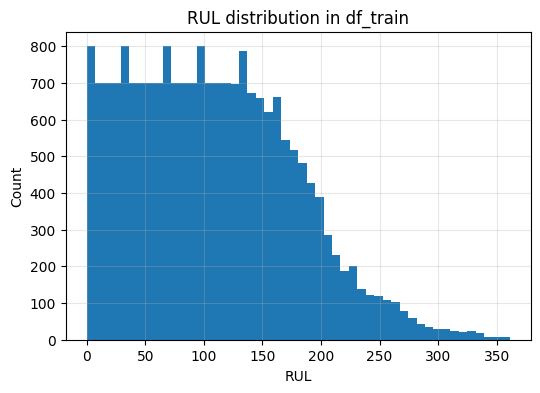

In [4]:
import matplotlib.pyplot as plt

def plot_rul_distribution_df(df, rul_col="RUL", title="RUL distribution in df_train"):
    plt.figure(figsize=(6,4))
    df[rul_col].hist(bins=50)
    plt.xlabel("RUL")
    plt.ylabel("Count")
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.show()

plot_rul_distribution_df(df_train_global, rul_col="RUL")


In [5]:
print("min:", y_eol_all.min().item())
print("max:", y_eol_all.max().item())
print("mean:", y_eol_all.mean().item())
print("std:", y_eol_all.std().item())


min: 1.0
max: 332.0
mean: 94.68464660644531
std: 61.689579010009766


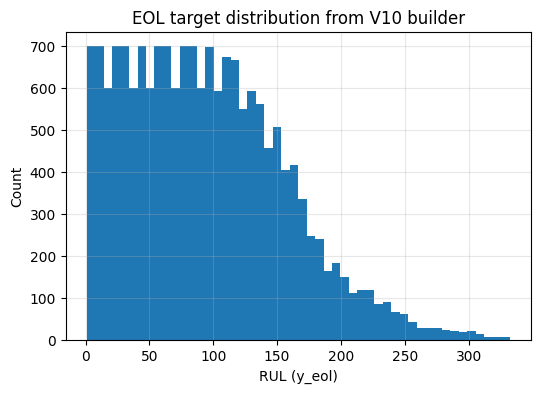

In [6]:
def plot_y_eol_distribution(y_eol, title="EOL target distribution (y_eol)"):
    y_np = y_eol.cpu().numpy()
    plt.figure(figsize=(6,4))
    plt.hist(y_np, bins=50)
    plt.xlabel("RUL (y_eol)")
    plt.ylabel("Count")
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.show()

plot_y_eol_distribution(y_eol_all, "EOL target distribution from V10 builder")


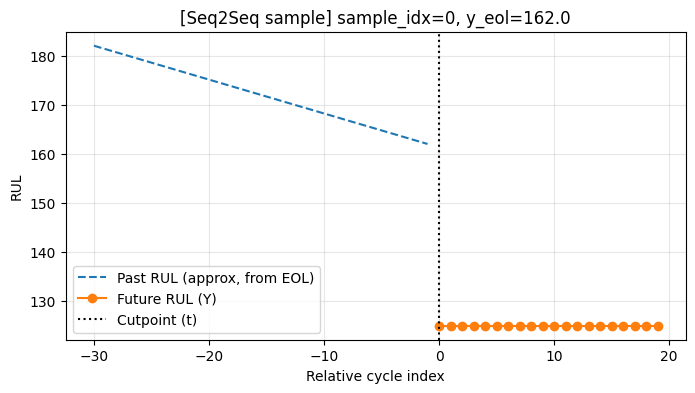

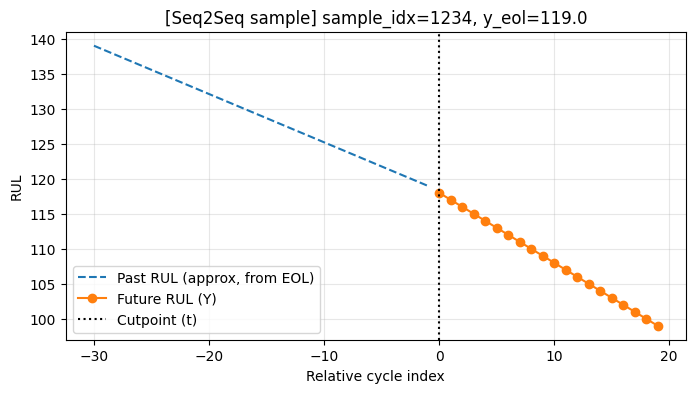

In [7]:
def plot_sample_window_rul(
    X_all, Y_all, y_eol_all,
    sample_idx=0,
    past_len=30,
    title_prefix="[Seq2Seq sample]"
):
    """
    Plottet für ein Sample:
    - Past-RUL (aus Y_all rekonstruiert oder separat übergeben)
      -> hier nutzen wir Y_all[:,0,0] als RUL(t)
    - Future-RUL (Y_all)
    - EOL-Target (y_eol_all)
    """

    # X_all wird hier nur zur Kontrolle genutzt (Länge checken)
    X_sample = X_all[sample_idx]          # (past_len, F)
    Y_sample = Y_all[sample_idx]          # (horizon, 1)
    y_eol = y_eol_all[sample_idx].item()  # scalar

    horizon = Y_sample.shape[0]

    # Wir visualisieren nur RUL(t) und RUL future:
    # RUL zum Ende des Past-Fensters = y_eol
    # RUL-Zukunft = Y_sample[:,0]
    rul_future = Y_sample[:, 0].cpu().numpy()

    plt.figure(figsize=(8,4))

    # Past-Bereich: wir zeichnen nur einen linearen Abfall von y_eol über past_len als Proxy
    # (optional – wenn du echten Past-RUL im df hast, kannst du den hier ersetzen)
    past_rul = np.linspace(y_eol + horizon, y_eol, past_len)
    t_past = np.arange(-past_len, 0)
    t_future = np.arange(0, horizon)

    plt.plot(t_past, past_rul, label="Past RUL (approx, from EOL)", linestyle="--")
    plt.plot(t_future, rul_future, label="Future RUL (Y)", marker="o")

    plt.axvline(0, color="k", linestyle=":", label="Cutpoint (t)")

    plt.xlabel("Relative cycle index")
    plt.ylabel("RUL")
    plt.title(f"{title_prefix} sample_idx={sample_idx}, y_eol={y_eol:.1f}")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

plot_sample_window_rul(X_all, Y_all, y_eol_all, sample_idx=0, past_len=30)
plot_sample_window_rul(X_all, Y_all, y_eol_all, sample_idx=1234, past_len=30)


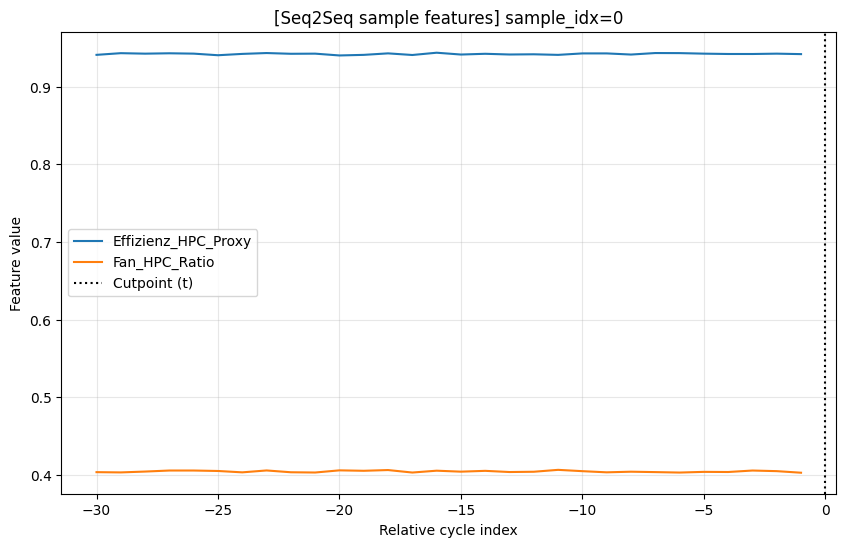

In [8]:
def plot_sample_window_features(
    X_all,
    feature_cols,
    sample_idx=0,
    features_to_plot=("S17", "Effizienz_HPC_Proxy", "Fan_HPC_Ratio"),
    past_len=30,
    title_prefix="[Seq2Seq sample features]"
):
    """
    Plottet ausgewählte Features im Past-Fenster.
    Annahme: X_all ist [N, past_len, F], feature_cols alignen mit letzterer Dimension.
    """

    X_sample = X_all[sample_idx].cpu().numpy()  # (past_len, F)

    # Map Feature-Name -> Index
    feat_idx = {name: i for i, name in enumerate(feature_cols)}

    t_past = np.arange(-past_len, 0)

    plt.figure(figsize=(10,6))

    for feat_name in features_to_plot:
        if feat_name not in feat_idx:
            print(f"Warning: feature '{feat_name}' not in feature_cols, skipping.")
            continue
        idx = feat_idx[feat_name]
        plt.plot(t_past, X_sample[:, idx], label=feat_name)

    plt.axvline(0, color="k", linestyle=":", label="Cutpoint (t)")
    plt.xlabel("Relative cycle index")
    plt.ylabel("Feature value")
    plt.title(f"{title_prefix} sample_idx={sample_idx}")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

plot_sample_window_features(
    X_all, feature_cols,
    sample_idx=0,
    features_to_plot=("S17", "Effizienz_HPC_Proxy", "Fan_HPC_Ratio"),
    past_len=30,
)

In [41]:
import importlib
import src.world_model_training as wmt

importlib.reload(wmt)

from src.world_model_training import train_simple_eol_mlp_on_seq2seq_samples

dfs = []
for fd_id in ["FD001"]: #, "FD002", "FD003", "FD004"
    df_train, _, _ = load_cmapps_subset(fd_id)  # ggf. add_rul=True etc.
    df_train = create_physical_features(df_train)
    df_train["FD_ID"] = fd_id
    dfs.append(df_train)

df_train_global = pd.concat(dfs, ignore_index=True)

simple_mlp, mlp_history = train_simple_eol_mlp_on_seq2seq_samples(
    df_train=df_train_global,
    feature_cols=feature_cols,
    past_len=30,
    horizon=20,
    max_rul=MAX_RUL,
    val_split=0.2,
    batch_size=256,
    num_epochs=30,
    lr=1e-3,
    device=device,
)


New columns successfully added. Current number of columns: 32
   Effizienz_HPC_Proxy  EGT_Drift  Fan_HPC_Ratio  RUL
0             0.941013        0.2       0.403737  125
1             0.943169        0.2       0.403406  125
2             0.942554       -1.8       0.404505  125
3             0.943025        0.2       0.405834  125
4             0.942581        1.2       0.405831  125
[EOLHeadV9] EOL samples from Seq2Seq builder
[EOLHeadV9] X_eol: torch.Size([15731, 30, 24]), y_eol: torch.Size([15731])
[EOLHeadV9] RUL stats: min=19.00, max=125.00, mean=89.02
[SimpleMLP] EOL samples from Seq2Seq builder
[SimpleMLP] X_eol: torch.Size([15731, 30, 24]), y_eol: torch.Size([15731])
[SimpleMLP] RUL stats: min=19.00, max=125.00, mean=89.02, std=35.55
[SimpleMLP] Baseline RMSE (predicting mean): 35.55
[SimpleMLP] Dataset sizes:
[SimpleMLP] total=15731, train=12585, val=3146
[SimpleMLP] Epoch 1/30 - train_loss: 57432.8366, val_loss: 3156.5431, val_RMSE: 56.17
  [VAL-Stats] preds mean/std: 46.32 / 

In [35]:
import importlib
import src.world_model_training as wmt

importlib.reload(wmt)

from src.world_model_training import train_world_model_eol_head_v9_from_seq2seq

dfs = []
for fd_id in ["FD001"]: #, "FD002", "FD003", "FD004"
    df_train, _, _ = load_cmapps_subset(fd_id)  # ggf. add_rul=True etc.
    df_train = create_physical_features(df_train)
    df_train["FD_ID"] = fd_id
    dfs.append(df_train)

df_train_global = pd.concat(dfs, ignore_index=True)

model_world_mt_eol, hist_eol = train_world_model_eol_head_v9_from_seq2seq(
    model=model_world_mt,
    df_train=df_train_global,  # FD001-Train-DF mit RUL & Physics-Features
    feature_cols=feature_cols,  # gleiche Featureliste wie beim World Model
    past_len=30,
    horizon=20,  # muss mit dem World Model Training übereinstimmen
    max_rul=MAX_RUL,
    val_split=0.2,
    batch_size=128,  # erhöht für mehr Samples
    num_epochs=50,
    lr=1e-3,
    #device=device,
)

New columns successfully added. Current number of columns: 32
   Effizienz_HPC_Proxy  EGT_Drift  Fan_HPC_Ratio  RUL
0             0.941013        0.2       0.403737  125
1             0.943169        0.2       0.403406  125
2             0.942554       -1.8       0.404505  125
3             0.943025        0.2       0.405834  125
4             0.942581        1.2       0.405831  125
[EOLHeadV9] EOL samples from Seq2Seq builder
[EOLHeadV9] X_eol: torch.Size([15731, 30, 24]), y_eol: torch.Size([15731])
[EOLHeadV9] RUL stats: min=19.00, max=125.00, mean=89.02
[EOLHeadV9] Dataset sizes:
[EOLHeadV9] total=15731, train=12585, val=3146
[EOLHeadV9] Epoch 1/50 - train_loss: 1272.1762, val_loss: 1241.9939, val_RMSE: 35.21
[EOLHeadV9] Epoch 2/50 - train_loss: 1270.4058, val_loss: 1242.0292, val_RMSE: 35.21
[EOLHeadV9] Epoch 3/50 - train_loss: 1269.8839, val_loss: 1242.1876, val_RMSE: 35.22
[EOLHeadV9] Epoch 4/50 - train_loss: 1269.2294, val_loss: 1242.7340, val_RMSE: 35.22
[EOLHeadV9] Epoch 5/50 

In [37]:
stats = (
    df_train_global
    .groupby("UnitNumber")["RUL"]
    .agg(["min", "max", "last", "mean"])
)
print(stats.head())
print("mean(last RUL):", stats["last"].mean())
print("min(last RUL):", stats["last"].min(), "max(last RUL):", stats["last"].max())


            min  max  last       mean
UnitNumber                           
1             0  125     0  83.984375
2             0  125     0  97.560976
3             0  125     0  81.005587
4             0  125     0  83.333333
5             0  125     0  95.724907
mean(last RUL): 0.0
min(last RUL): 0 max(last RUL): 0


In [38]:
from src.world_model_training import build_eol_sequences_from_df  # gleiche Import-Quelle!

X_eol, y_eol = build_eol_sequences_from_df(
    df=df_train_global,               # EXAKT das gleiche df_train wie im Call oben
    feature_cols=feature_cols,
    past_len=30,
    max_rul=MAX_RUL,
    unit_col="UnitNumber",
    cycle_col="TimeInCycles",
    rul_col="RUL",
)

print("y_eol shape:", y_eol.shape)
print("min:", y_eol.min().item(),
      "max:", y_eol.max().item(),
      "mean:", y_eol.mean().item())

print("first 10 y_eol:", y_eol[:10].tolist())


y_eol shape: torch.Size([100])
min: 0.0 max: 125.0 mean: 83.16999816894531
first 10 y_eol: [60.0, 125.0, 78.0, 125.0, 125.0, 37.0, 19.0, 34.0, 97.0, 105.0]


In [ ]:
# Build samples to visualize EOL distribution
from src.world_model_training import build_seq2seq_multitask_samples_from_df

# Build samples with the new masked builder
X_all, Y_all, y_eol_all, mask_all = build_seq2seq_multitask_samples_from_df(
    df=df_train_global,
    feature_cols=feature_cols,
    past_len=30,
    horizon=20,
    max_rul=MAX_RUL,
    unit_col="UnitNumber",
    cycle_col="TimeInCycles",
    rul_col="RUL",
)

print(f"Built samples: X={X_all.shape}, Y={Y_all.shape}, y_eol={y_eol_all.shape}, mask={mask_all.shape}")
print(f"EOL stats: min={y_eol_all.min().item():.2f}, max={y_eol_all.max().item():.2f}, mean={y_eol_all.mean().item():.2f}, std={y_eol_all.std().item():.2f}")


In [ ]:
from src.data_loading import load_cmapps_subset
from src.additional_features import create_physical_features
from src.config import GLOBAL_FEATURE_COLS, MAX_RUL
from src.models.world_model import WorldModelEncoderDecoderMultiTaskV9
from src.training import build_eol_sequences_from_df  # ggf. anpassen, falls woanders

device = "cuda" if torch.cuda.is_available() else "cpu"

# ------------------------------------------------------------------
# 1) FD001 Testdaten laden + physikalische Features hinzufügen
# ------------------------------------------------------------------
df_train_fd001, df_test_fd001, rul_test_fd001 = load_cmapps_subset("FD001", add_rul=True)
df_test_fd001 = create_physical_features(df_test_fd001)

# gleiche Featureliste wie im Training
numeric_cols = df_test_fd001[GLOBAL_FEATURE_COLS].select_dtypes(include=["number"]).columns.tolist()
feature_cols = numeric_cols
past_len = 30

print("============================================================")
print("Building Test EOL Sequences...")
print("============================================================")

X_test_eol, y_test_eol = build_eol_sequences_from_df(
    df=df_test_fd001,
    feature_cols=feature_cols,
    past_len=past_len,
    max_rul=MAX_RUL,
    unit_col="UnitNumber",
    cycle_col="TimeInCycles",
    rul_col="RUL",
)

print(f"Test EOL X: {X_test_eol.shape}, y: {y_test_eol.shape}")
print(
    "Test RUL stats: min={:.2f}, max={:.2f}, mean={:.2f}".format(
        y_test_eol.min().item(), y_test_eol.max().item(), y_test_eol.mean().item()
    )
)

# ------------------------------------------------------------------
# 2) V9-Modell mit trainiertem EOL-Head verwenden
#    -> hier wird angenommen, dass `model_v9_eol` bereits im RAM ist.
#    Falls du von Disk lädst, musst du vorher state_dict laden.
# ------------------------------------------------------------------
model_v9_eol.to(device)
model_v9_eol.eval()

with torch.no_grad():
    X_test_eol_device = X_test_eol.to(device)

    # Wir nutzen die ganz normale forward-Signatur:
    # decoder_targets=None, horizon=1 (Decoder interessiert hier nicht)
    _, eol_pred = model_v9_eol(
        encoder_inputs=X_test_eol_device,
        decoder_targets=None,
        teacher_forcing_ratio=0.0,
        horizon=1,
    )

    pred_rul = eol_pred.squeeze(-1).cpu().numpy()
    true_rul = y_test_eol.cpu().numpy()

print("============================================================")
print("First 10 predictions vs. true RUL")
print("============================================================")
print("pred_rul (first 10):", np.round(pred_rul[:10], 3))
print("true_rul (first 10):", true_rul[:10])

# ------------------------------------------------------------------
# 3) EOL-Metriken berechnen: MSE, RMSE, MAE, Bias, NASA
# ------------------------------------------------------------------
errors = pred_rul - true_rul

mse = float(np.mean(errors**2))
rmse = float(np.sqrt(mse))
mae = float(np.mean(np.abs(errors)))
bias = float(np.mean(errors))

def nasa_score_from_errors(errors_np: np.ndarray):
    """
    NASA PHM08 Score:
    - errors = y_pred - y_true
    - overprediction (error > 0) wird exponentiell härter bestraft
    """
    errors_clipped = np.clip(errors_np, -100.0, 100.0)
    scores = np.where(
        errors_clipped >= 0.0,
        np.exp(errors_clipped / 10.0) - 1.0,
        np.exp(-errors_clipped / 13.0) - 1.0,
    )
    return float(scores.sum()), float(scores.mean())

nasa_sum, nasa_mean = nasa_score_from_errors(errors)

print("============================================================")
print("EOL Metrics (Test Set) - WorldModel V9 EOL-Head")
print("============================================================")
print(f"MSE:  {mse:8.3f}")
print(f"RMSE: {rmse:8.3f}")
print(f"MAE:  {mae:8.3f}")
print(f"Bias: {bias:8.3f}")
print()
print(f"NASA Score (sum):   {nasa_sum:8.3f}")
print(f"NASA Score (mean):  {nasa_mean:8.3f}")
print(f"Number of engines:  {len(true_rul)}")
print("============================================================")

# ------------------------------------------------------------------
# 4) Ergebnisse als DataFrame (für Analyse / Plots)
# ------------------------------------------------------------------
# Annahme: alle 100 Engines sind lang genug -> IDs 1..100.
# Falls du später FDs hast, bei denen Units wegen past_len geskippt werden,
# müsstest du hier explizit die gültigen unit_ids aus df_test_fd001 ableiten.
unit_ids = np.sort(df_test_fd001["unit_nr"].unique())
if len(unit_ids) != len(true_rul):
    print("[WARN] Unit-ID-Anzahl != Anzahl EOL-Samples – "
          "hier würde man besser die IDs beim Sequenzbau mitloggen.")
    unit_ids = np.arange(1, len(true_rul) + 1)

results_df = pd.DataFrame(
    {
        "FD_ID": ["FD001"] * len(true_rul),
        "UnitNumber": unit_ids,
        "true_rul": true_rul,
        "pred_rul": pred_rul,
        "error": errors,
    }
)

print("Example rows from results_df:")
display(results_df.head())


TypeError: load_cmapps_subset() got an unexpected keyword argument 'add_rul'

In [ ]:
# --- GLOBAL TEST ---
dfs_test = []

for fd_id in ["FD001"]:  #"FD002", "FD003", "FD004"
    df_train, df_test, rul_test = load_cmapps_subset(fd_id)

    # 1) MaxTime pro Unit im TEST berechnen
    max_cycles = (
        df_test.groupby("UnitNumber")["TimeInCycles"]
        .max()
        .rename("MaxTime")
        .reset_index()
    )
    df_test = df_test.merge(max_cycles, on="UnitNumber", how="left")

    # 2) RUL_last pro Unit aus rul_test bauen
    #    Wir gehen davon aus: rul_test ist in der Reihenfolge Unit 1..N
    units = (
        df_test[["UnitNumber"]]
        .drop_duplicates()
        .sort_values("UnitNumber")
        .reset_index(drop=True)
    )
    rul_df = pd.DataFrame({
        "UnitNumber": units["UnitNumber"].values,
        "RUL_last": rul_test.reshape(-1),
    })

    df_test = df_test.merge(rul_df, on="UnitNumber", how="left")

    # 3) RUL(t) = RUL_last + (MaxTime - TimeInCycles)
    df_test["RUL"] = df_test["RUL_last"] + (df_test["MaxTime"] - df_test["TimeInCycles"])

    # 4) Optional: RUL clamping wie im Training
    df_test["RUL"] = df_test["RUL"].clip(upper=MAX_RUL)

    # 5) Physikfeatures ergänzen
    df_test = create_physical_features(df_test)

    # 6) FD_ID hinzufügen
    df_test["FD_ID"] = fd_id

    dfs_test.append(df_test)

df_test_global = pd.concat(dfs_test, ignore_index=True)

print("df_test_global columns:", df_test_global.columns)
print(df_test_global[["FD_ID", "UnitNumber", "TimeInCycles", "MaxTime", "RUL"]].head())

import importlib
import src.world_model_training as wmt

importlib.reload(wmt)

from src.world_model_training import evaluate_world_model_eol

eol_metrics = evaluate_world_model_eol(
    model=model_world_mt,
    df_global_test=df_test_global,
    feature_cols=feature_cols,
    past_len=30,   # konsistent mit deinem LSTM
)

print("EOL metrics (World Model, literature-style):")
for k, v in eol_metrics.items():
    print(f"{k}: {v}")


New columns successfully added. Current number of columns: 33
   Effizienz_HPC_Proxy  EGT_Drift  Fan_HPC_Ratio    RUL
0             0.941903        0.3       0.405617  125.0
1             0.941083        1.3       0.403985  125.0
2             0.941997        1.3       0.404842  125.0
3             0.941000       -0.7       0.405550  125.0
4             0.942237       -1.7       0.404810  125.0
df_test_global columns: Index(['UnitNumber', 'TimeInCycles', 'Setting1', 'Setting2', 'Setting3',
       'Sensor1', 'Sensor2', 'Sensor3', 'Sensor4', 'Sensor5', 'Sensor6',
       'Sensor7', 'Sensor8', 'Sensor9', 'Sensor10', 'Sensor11', 'Sensor12',
       'Sensor13', 'Sensor14', 'Sensor15', 'Sensor16', 'Sensor17', 'Sensor18',
       'Sensor19', 'Sensor20', 'Sensor21', 'ConditionID', 'MaxTime',
       'RUL_last', 'RUL', 'Effizienz_HPC_Proxy', 'EGT_Drift', 'Fan_HPC_Ratio',
       'FD_ID'],
      dtype='object')
   FD_ID  UnitNumber  TimeInCycles  MaxTime    RUL
0  FD001           1             1     

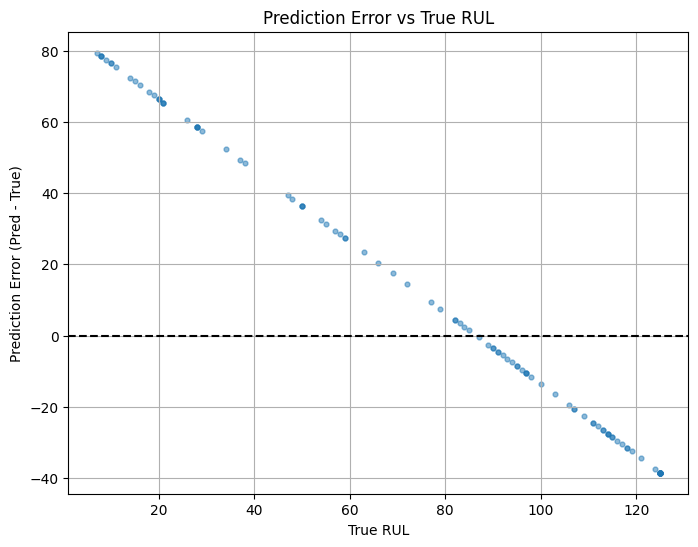

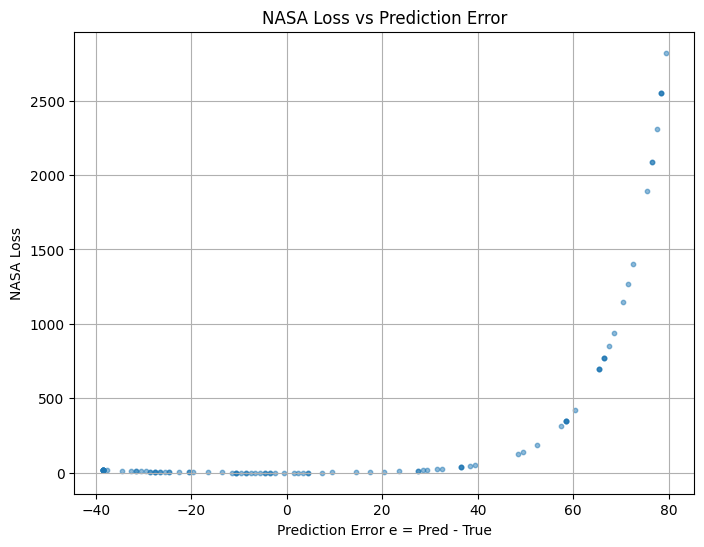

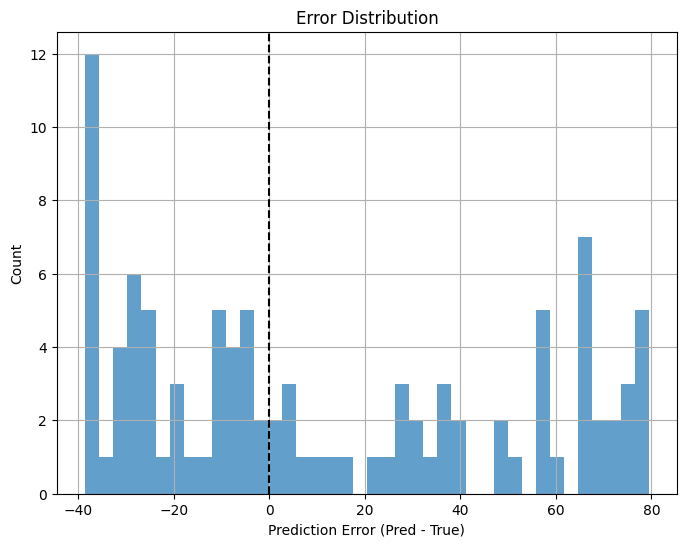

In [37]:
import matplotlib.pyplot as plt
import numpy as np

# Extract results_df from eol_metrics if available
if 'eol_metrics' in globals() and 'results_df' in eol_metrics:
    results_df = eol_metrics["results_df"]
else:
    raise ValueError("eol_metrics not found. Please run the evaluation first (Cell 2).")

true_rul = results_df["true_rul"].values
pred_rul = results_df["pred_rul"].values
errors = pred_rul - true_rul

plt.figure(figsize=(8,6))
plt.scatter(true_rul, errors, alpha=0.5, s=12)
plt.axhline(0, color='k', linestyle='--')
plt.xlabel("True RUL")
plt.ylabel("Prediction Error (Pred - True)")
plt.title("Prediction Error vs True RUL")
plt.grid(True)
plt.show()

def nasa_loss(e):
    if e >= 0:
        return np.exp(e / 10.0) - 1.0
    else:
        return np.exp(-e / 13.0) - 1.0

errors = pred_rul - true_rul
nasa_values = np.array([nasa_loss(e) for e in errors])

plt.figure(figsize=(8,6))
plt.scatter(errors, nasa_values, alpha=0.5, s=10)
plt.xlabel("Prediction Error e = Pred - True")
plt.ylabel("NASA Loss")
plt.title("NASA Loss vs Prediction Error")
plt.grid(True)
plt.show()

plt.figure(figsize=(8,6))
plt.hist(errors, bins=40, alpha=0.7)
plt.axvline(0, color='k', linestyle='--')
plt.xlabel("Prediction Error (Pred - True)")
plt.ylabel("Count")
plt.title("Error Distribution")
plt.grid(True)
plt.show()



In [29]:
import numpy as np
import pandas as pd

# Falls noch nicht geschehen:
# results_df = pd.DataFrame({"true_rul": true_rul, "pred_rul": pred_rul})

true_rul = results_df["true_rul"].values.astype(float)
pred_rul = results_df["pred_rul"].values.astype(float)

# 1. Lineare Regression: true ≈ alpha * pred + beta
alpha, beta = np.polyfit(pred_rul, true_rul, deg=1)

print(f"Kalibrierung: true ≈ {alpha:.4f} * pred + {beta:.4f}")


Kalibrierung: true ≈ 0.4365 * pred + 37.2250


C:\Users\rober\AppData\Local\Temp\ipykernel_13180\4055109382.py:11: RankWarning: Polyfit may be poorly conditioned
  alpha, beta = np.polyfit(pred_rul, true_rul, deg=1)


In [30]:
MAX_RUL = 125  # falls du in FD001 mit 125 clampst

pred_rul_calib = alpha * pred_rul + beta

# Optional: auf physikalisch sinnvolle Grenzen begrenzen
pred_rul_calib_clipped = np.clip(pred_rul_calib, 0, MAX_RUL)

results_df["pred_rul_calib"] = pred_rul_calib
results_df["pred_rul_calib_clipped"] = pred_rul_calib_clipped


In [31]:
def compute_basic_metrics(y_true, y_pred):
    errors = y_pred - y_true
    mse = np.mean(errors**2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(errors))
    bias = np.mean(errors)
    return mse, rmse, mae, bias, errors

def nasa_loss_from_errors(errors):
    # NASA/PHM08 Score pro Sample
    loss = np.where(
        errors >= 0,
        np.exp(errors / 10.0) - 1.0,
        np.exp(-errors / 13.0) - 1.0,
    )
    return loss


In [32]:
# A) Original (zur Kontrolle)
mse_orig, rmse_orig, mae_orig, bias_orig, errors_orig = compute_basic_metrics(true_rul, pred_rul)
nasa_orig = nasa_loss_from_errors(errors_orig)
print("== Original ==")
print(f"MSE:  {mse_orig:.3f}")
print(f"RMSE: {rmse_orig:.3f}")
print(f"MAE:  {mae_orig:.3f}")
print(f"Bias: {bias_orig:.3f}")
print(f"NASA mean: {nasa_orig.mean():.3f}")

# B) Kalibriert (ungeclippt)
mse_cal, rmse_cal, mae_cal, bias_cal, errors_cal = compute_basic_metrics(true_rul, pred_rul_calib)
nasa_cal = nasa_loss_from_errors(errors_cal)
print("\n== Kalibriert (ungeclippt) ==")
print(f"MSE:  {mse_cal:.3f}")
print(f"RMSE: {rmse_cal:.3f}")
print(f"MAE:  {mae_cal:.3f}")
print(f"Bias: {bias_cal:.3f}")
print(f"NASA mean: {nasa_cal.mean():.3f}")

# C) Kalibriert + geclippt
mse_cal_c, rmse_cal_c, mae_cal_c, bias_cal_c, errors_cal_c = compute_basic_metrics(true_rul, pred_rul_calib_clipped)
nasa_cal_c = nasa_loss_from_errors(errors_cal_c)
print("\n== Kalibriert + geclippt [0, MAX_RUL] ==")
print(f"MSE:  {mse_cal_c:.3f}")
print(f"RMSE: {rmse_cal_c:.3f}")
print(f"MAE:  {mae_cal_c:.3f}")
print(f"Bias: {bias_cal_c:.3f}")
print(f"NASA mean: {nasa_cal_c.mean():.3f}")


== Original ==
MSE:  1723.206
RMSE: 41.512
MAE:  34.830
Bias: 10.832
NASA mean: 286.731

== Kalibriert (ungeclippt) ==
MSE:  1605.867
RMSE: 40.073
MAE:  35.847
Bias: -0.000
NASA mean: 105.794

== Kalibriert + geclippt [0, MAX_RUL] ==
MSE:  1605.867
RMSE: 40.073
MAE:  35.847
Bias: -0.000
NASA mean: 105.794
